In [14]:
import requests
from typing import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image

In [15]:
class AqiState(TypedDict):
    city : str
    longitude : float
    latitude : float
    aqi : float
    category : str
    description : str
    color : str

In [16]:
# node
def measure_aqi(state : AqiState) -> AqiState:
    city = state['city']
    city_details = requests.get(f"https://geocoding-api.open-meteo.com/v1/search?name={city}").json()

    state['longitude'] = city_details['results'][0]['longitude']
    state['latitude'] = city_details['results'][0]['latitude']
    
    aqi_details = requests.get(f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={state['latitude']}&longitude={state['longitude']}&current=us_aqi").json()
    state['aqi'] = aqi_details['current']['us_aqi']
    return state

In [17]:
def label_aqi(state : AqiState) -> AqiState:
    aqi_value = state['aqi']

    if 0 <= aqi_value <= 50:
        state['category'] = "Good"
        state['description'] = "Air quality is satisfactory, and air pollution poses little or no risk."
        state['color'] = "Green"

    elif 51 <= aqi_value <= 100:
        state['category'] = "Moderate"
        state['description'] = "Air quality is acceptable. Some people who are sensitive may experience minor issues."
        state['color'] = "Yellow"

    elif 101 <= aqi_value <= 150:
        state['category'] = "Unhealthy for Sensitive Groups"
        state['description'] = "Sensitive groups may experience health effects. General public is less likely to be affected."
        state['color'] = "Orange"

    elif 151 <= aqi_value <= 200:
        state['category'] = "Unhealthy"
        state['description'] = "Some people may experience health effects; sensitive groups may experience more serious effects."
        state['color'] = "Red"

    elif 201 <= aqi_value <= 300:
        state['category'] = "Very Unhealthy"
        state['description'] = "Health alert: everyone may experience more serious health effects."
        state['color'] = "Purple"

    elif aqi_value >= 301:
        state['category'] = "Hazardous"
        state['description'] = "Health warning of emergency conditions. Everyone is likely to be affected."
        state['color'] = "Maroon"

    else:
        state['category'] = "Invalid"
        state['description'] = "Invalid AQI value."
        state['color'] = "N/A"

    return state

In [18]:
graph = StateGraph(AqiState)

graph.add_node("measure_aqi", measure_aqi)
graph.add_node("label_aqi", label_aqi)

graph.add_edge(START, "measure_aqi")
graph.add_edge("measure_aqi", "label_aqi")
graph.add_edge("label_aqi", END)

workflow = graph.compile()

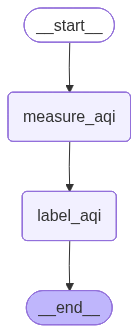

In [19]:
Image(workflow.get_graph().draw_mermaid_png())

In [29]:
initial_state = {"city" : "Delhi"}
final_state = workflow.invoke(initial_state)
final_state

{'city': 'Delhi',
 'longitude': 77.23149,
 'latitude': 28.65195,
 'aqi': 158,
 'category': 'Unhealthy',
 'description': 'Some people may experience health effects; sensitive groups may experience more serious effects.',
 'color': 'Red'}